In [6]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

import CompPhy as cp

plt.style.use("custom.matplotlibrc")

# Implementation of Exact Results

1 / J       m          e   
 0.25   1.0000000   -8.000 
 1.0    0.9992758   -1.997 
 2.0    0.9113194   -0.873 
 3.0    0.0000000   -0.272 


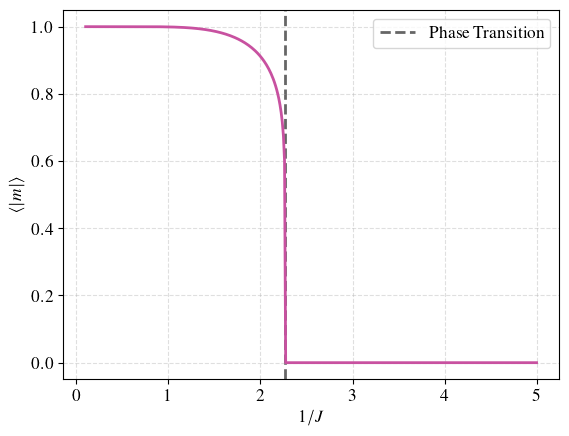

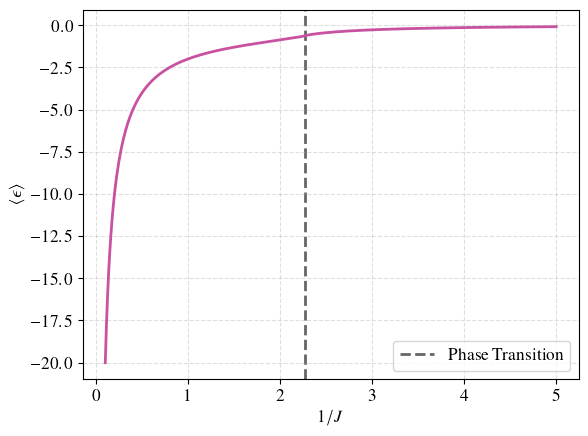

In [8]:
J_c = 0.5 * np.log(1 + np.sqrt(2))


@np.vectorize
def mean_mag_per_site(J):

    if J <= J_c:
        return 0

    return np.power(1 - 1 / np.sinh(2 * J) ** 4, 0.125)


def mean_energy_per_site(J):
    tanh2 = np.tanh(2 * J) ** 2
    fac = -J * np.cosh(2 * J) / np.sinh(2 * J)
    term1 = 2 * tanh2 - 1
    term2 = scipy.special.ellipk(4 * (1 - tanh2) * tanh2)

    return fac * (1 + 2 / np.pi * term1 * term2)


# Proof that it works
print("{:^6}".format("1 / J"), "{:^12}".format("m"), "{:^7}".format("e"))
for J in [4, 1, 0.5, 1 / 3]:
    j = "{:^6}".format(1 / J)
    m = "{:^12.7f}".format(mean_mag_per_site(J))
    e = "{:^7.3f}".format(mean_energy_per_site(J))
    print(j, m, e)

var = np.linspace(0.1, 5, 400)

# mag per site
plt.figure(0)
plt.plot(var, mean_mag_per_site(1 / var), linewidth=2)
plt.xlabel(r"$1 / J$")
plt.ylabel(r"$\expval{\abs{m}}$")
plt.grid(alpha=0.4, linestyle="--")
plt.axvline(
    1 / J_c,
    label="Phase Transition",
    color="black",
    linestyle="--",
    alpha=0.6,
    linewidth=2,
    zorder=0,
)
plt.legend()
plt.savefig(r"Exercise_5/mean_mag_per_site.pdf")

# e per site
plt.figure(1)
plt.plot(var, mean_energy_per_site(1 / var), linewidth=2)
plt.xlabel(r"$1 / J$")
plt.ylabel(r"$\expval{\epsilon}$")
plt.grid(alpha=0.4, linestyle="--")
plt.axvline(
    1 / J_c,
    label="Phase Transition",
    color="black",
    linestyle="--",
    alpha=0.6,
    linewidth=2,
    zorder=0,
)
plt.legend()
plt.savefig(r"Exercise_5/mean_energy_per_site.pdf")

# MCMC in 2D

## Generate Ensembles and Cutting off Burn in

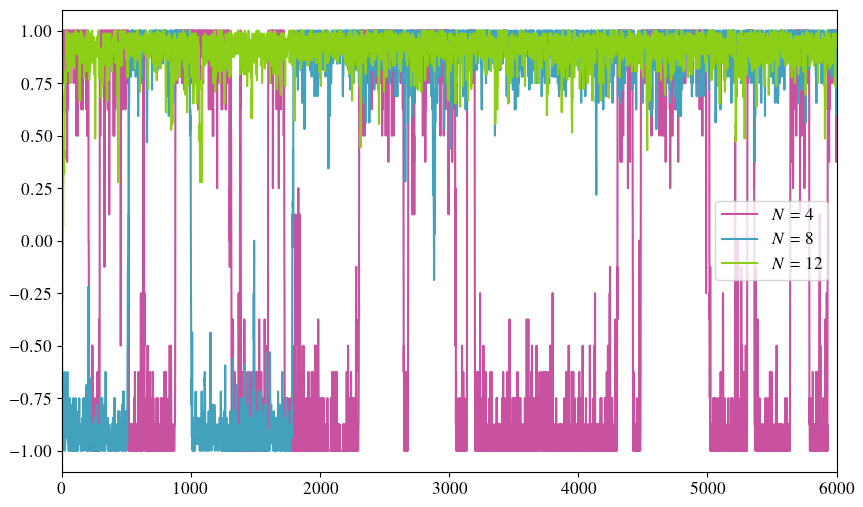

In [19]:
# from CompPhy.mcmc import Ising2D
from CompPhy.autocorrelation import normalized_autocorrelation
from CompPhy import mcmc

np.random.seed(1)

plt.style.use("custom.matplotlibrc")


plt.figure(0, figsize=(10, 6))
burn_in = [0, 0, 0]

for b, n in zip(burn_in, [4, 8, 12]):
    # model = cp.mcmc.Ising2D(J=0.5, h=0, lattice_sites=n)
    model = cp.Ising2D(j=0.5, h=0, lattice_sites=n)
    config_name = f"Exercise_5/ensemble_{n}"
    
    number_of_configs = pow(10, 5)
    t = range(number_of_configs)
    # configs = model(number_of_configs)
    configs = model.generate_sample(number_of_configs)


    m = configs.mean(axis=(1, 2))
    plt.xlim((0, 6000))
    t = list(range(len(m)))
    p = plt.plot(t, m, label=f"$N = {n}$")
    plt.axvline(t[b], color=p[0].get_color(), linestyle="--")
    
    configs = configs[b:]
    np.save(config_name, configs)


plt.legend()
plt.savefig("Exercise_5/burn_in.pdf")

<Figure size 640x480 with 0 Axes>

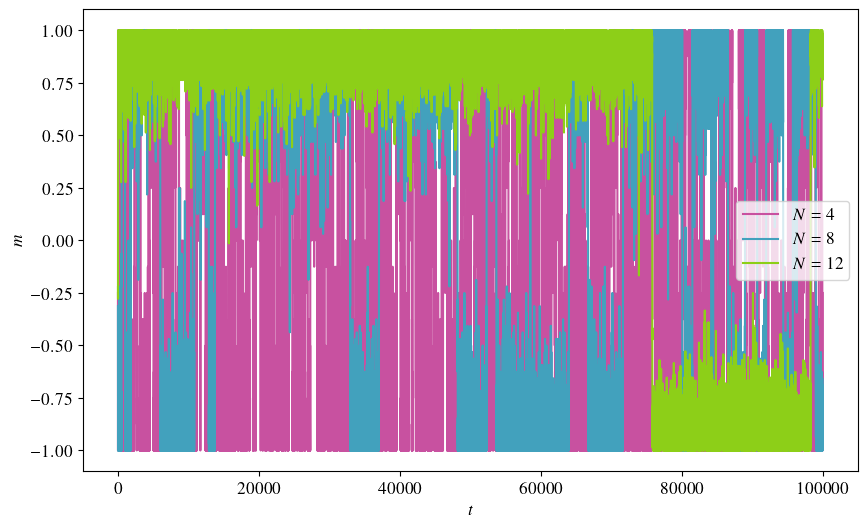

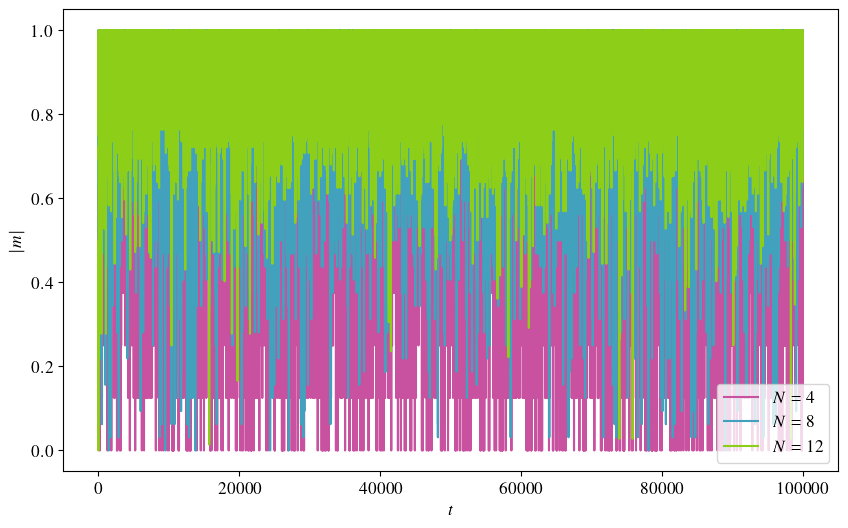

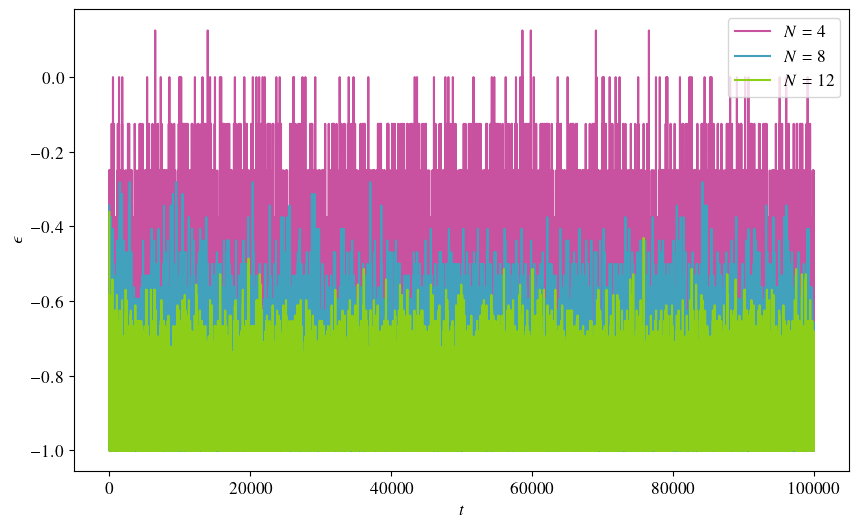

In [20]:
from CompPhy.mcmc import Ising2D
from CompPhy.autocorrelation import normalized_autocorrelation

np.random.seed(0)

plt.style.use("custom.matplotlibrc")


plt.figure(0, figsize=(10, 6))
plt.figure(1, figsize=(10, 6))
plt.figure(2, figsize=(10, 6))

for n in [4, 8, 12]:
    config_name = f"Exercise_5/ensemble_{n}"
    
    configs = np.load(config_name + ".npy")
    t = range(configs.shape[0])
    
    # Plot m
    m = configs.mean(axis=(1, 2))
    np.save(f"{config_name}_m", m)
    plt.figure(0)
    plt.plot(t, m, label=f"$N = {{{n}}}$")
    # plt.xscale("log")
    plt.xlabel("$t$")
    plt.ylabel("$m$")
   
    # Plot |m| 
    plt.figure(1)
    plt.plot(t, abs(m), label=f"$N = {{{n}}}$")
    # plt.xscale("log")
    plt.xlabel("$t$")
    plt.ylabel(r"$\abs{m}$")
    
    # Plot e 
    plt.figure(2)
    e = model.calc_h(configs) / n**2
    np.save(config_name + "_e", e)
    plt.plot(t, e, label=f"$N = {{{n}}}$")
    plt.ylabel("$\\epsilon$")
    plt.xlabel("$t$")
    # plt.xscale("log")
    
    plt.figure(3)

plt.figure(0)
plt.legend()
plt.savefig("Exercise_5/mcmc_m.pdf")
plt.figure(1)
plt.legend()
plt.savefig("Exercise_5/mcmc_abs_m.pdf")
plt.figure(2)
plt.savefig("Exercise_5/mcmc_e.pdf")
plt.legend()
    
    

## integrated autocorrelation time 

In [16]:
import numpy as np
import sys

m = {n: np.load(f"Exercise_5/ensemble_{n}_m.npy") for n in [4, 8, 12]}
e = {n: np.load(f"Exercise_5/ensemble_{n}_e.npy") for n in [4, 8, 12]}

for n in [4, 8, 12]:
    print(m[n].shape)
    print(sys.getsizeof(m[n]))

(100000,)
800112
(100000,)
800112
(100000,)
800112


In [17]:
from CompPhy.autocorrelation import integrated_autocorrelation

m_tau = {}
e_tau = {}

for n, mag in m.items():
    tau_m = int(np.ceil(integrated_autocorrelation(mag)))
    print(f"n: {n}, tau_m: {tau_m}")
    tau_m = int(np.ceil(integrated_autocorrelation(abs(mag))))
    print(f"n: {n}, tau_abs(m): {tau_m}")

    m_tau[n] = tau_m
for n, ev in e.items():
    tau_e = int(np.ceil(integrated_autocorrelation(ev)))
    print(f"n: {n}, tau_e: {tau_e}")

    e_tau[n] = tau_e

n: 4, tau_m: 112
n: 4, tau_abs(m): 2
n: 8, tau_m: 1479
n: 8, tau_abs(m): 4
n: 12, tau_m: 10798
n: 12, tau_abs(m): 5
n: 4, tau_e: 2
n: 8, tau_e: 3
n: 12, tau_e: 3


# Bootstrap

In [24]:
from CompPhy.bootstrap import Bootstrap
from CompPhy.autocorrelation import blocking

def first_moment(x):
    return x

# B, a = 100, 10000

e_mean = []
m_mean = []
m_err = []
e_err = []
for n in [4, 8 ,12]:
    data = blocking(m[n], tau=2 * m_tau[n])
    a = len(data) // 5
    B = a // 5

    bootstrap = Bootstrap(data, B=B, a=a)
    mean, uncertainty = bootstrap.estimate(first_moment)
    m_mean.append(mean)
    m_err.append(uncertainty)

    print("m", n, mean, uncertainty)
    
    data = blocking(e[n], tau=2 * e_tau[n])
    a = len(data) // 5
    B = a // 5 
    bootstrap = Bootstrap(blocking(e[n], tau=e_tau[n]), B=B, a=a)
    mean, uncertainty = bootstrap.estimate(first_moment)
    e_mean.append(mean)
    e_err.append(uncertainty)

    print("e", n, mean, uncertainty, end="\n\n")

m 4 -0.05706438750000001 0.013024906331830902
e 4 -0.8787778375 0.0022791850747238035

m 8 0.214600434375 0.017825465006474882
e 8 -0.8722592463825962 0.0014744378352880571

m 12 0.5022958420138889 0.01714514514029897
e 12 -0.8728029021620881 0.0009489679041937728



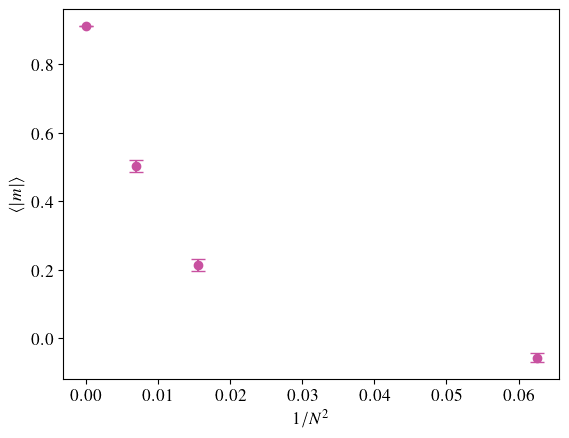

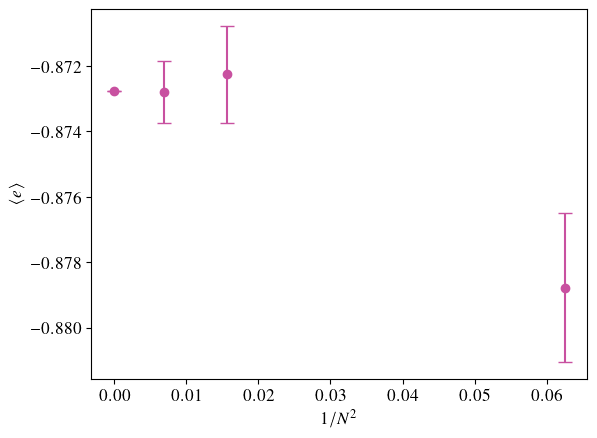

In [25]:
n = np.array([4, 8, 12])
x = np.append(1 / n**2, 0)

plt.figure(0)
plt.errorbar(x, [*m_mean, mean_mag_per_site(0.5)], yerr=[*m_err, 0], linestyle="", marker="o", capsize=5)
plt.xlabel("$1 / N^2$")
plt.ylabel(r"$\expval{\abs{m}}$")
plt.savefig("Exercise_5/abs_m_mean_bootstrap.pdf")

plt.figure(1)
plt.errorbar(x, [*e_mean, mean_energy_per_site(0.5)], yerr=[*e_err, 0], linestyle="", marker="o", capsize=5)
plt.ylabel(r"$\expval{e}$")
plt.xlabel(r"$1 / N^2$")
plt.savefig("Exercise_5/e_mean_bootstrap.pdf")